## Day 48 Lecture 1 Assignment

In this assignment, we will apply hierarchical clustering to a dataset containing the locations of all Starbucks in the U.S.

Note: this assignment uses geographical data and maps, which will require the use of two specific packages: haversine and plotly. Both of these can be pip installed.

In [0]:
pip install haversine

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from haversine import haversine
import plotly.express as px
import seaborn as sns
sns.set()

Below are some convenience functions for calculating geographical distance matrices using lat-long data and plotting a dendrogram by combining a scikit-learn model with scipy's dendrogram plotting functionality.

In [0]:
def geo_sim_matrix(df, col_name = 'Coordinates'):
    """
    A function that computes a geographical distance matrix (in miles).
    Each row in the dataframe should correspond to one location.
    In addition, the dataframe must have a column containing the lat-long of each location as a tuple (i.e. (lat, long)).
    
    Parameters:
        df (pandas dataframe): an nxm dataframe containing the locations to compute similarities between.
        col (string): the name of the column containing the lat-long tuples.
        
    Returns:
        distance (pandas dataframe): an nxn distance matrix between the geographical coordinates of each location.
    """
    
    df = df.copy()
    df.reset_index(inplace=True)
    haver_vec = np.vectorize(haversine, otypes=[np.float32])
    distance = df.groupby('index').apply(lambda x: pd.Series(haver_vec(df[col_name], x[col_name])))
    distance = distance / 1.609344
    distance.columns = distance.index
    
    return distance


def plot_dendrogram(model, **kwargs):
    """
    A basic function for plotting a dendrogram. Sourced from the following link:
    https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
    
    Parameters:
        model (object of class sklearn.cluster.hierarchical.AgglomerativeClustering): a fitted scikit-learn hierarchical clustering model.
    
    Output: a dendrogram based on the model based in the parameters.
    
    Returns: N/A    
    """
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

This dataset contains the latitude and longitude (as well as several other details we will not be using) of every Starbucks in the world as of February 2017. Each row consists of the following features, which are generally self-explanatory:

- Brand
- Store Number
- Store Name
- Ownership Type
- Street Address
- City
- State/Province
- Country
- Postcode
- Phone Number
- Timezone
- Longitude
- Latitude

Load in the dataset.

In [0]:
# answer goes here
df = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Clustering/starbucks_locations.csv')
df.head(2)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42


Begin by narrowing down the dataset to a specific geographic area of interest. Since we will need to manually compute a distance matrix, which will be on the order of $n^{2}$ in terms of size, we would recommend choosing an area with 3000 or less locations. In this example, we will use California, which has about 2800 locations. Feel free to choose a different region that is of more interest to you, if desired.

Subset the dataframe to only include records for Starbucks locations in California.

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25600 entries, 0 to 25599
Data columns (total 13 columns):
Brand             25600 non-null object
Store Number      25600 non-null object
Store Name        25600 non-null object
Ownership Type    25600 non-null object
Street Address    25598 non-null object
City              25585 non-null object
State/Province    25600 non-null object
Country           25600 non-null object
Postcode          24078 non-null object
Phone Number      18739 non-null object
Timezone          25600 non-null object
Longitude         25599 non-null float64
Latitude          25599 non-null float64
dtypes: float64(2), object(11)
memory usage: 2.5+ MB


In [0]:
# answer goes here
df1 = df.loc[(df['State/Province']=='IL') & (df['Country']=='US') & (df['Postcode'].str.startswith('606'))]
df1

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
17477,Starbucks,75935-101330,Marriott - Bedford Park - Entrance,Licensed,6520 S Cicero Ave,Bedford Park,IL,US,606385804,7085949500,GMT-06:00 America/Chicago,-87.74,41.77
17516,Starbucks,15963-166069,Target Chicago T-2781,Licensed,1101 W Jackson Blvd,Chicago,IL,US,606072905,312-279-3340,GMT-06:00 America/Chicago,-87.65,41.88
17517,Starbucks,2877-88641,Washington & Clinton,Company Owned,40 N. Clinton St.,Chicago,IL,US,60661,312/463-0331,GMT-06:00 America/Chicago,-87.64,41.88
17518,Starbucks,202-161424,Oak & Rush,Company Owned,1003 N Rush Street,Chicago,IL,US,60611,3129515436,GMT-06:00 America/Chicago,-87.63,41.90
17519,Starbucks,76178-93198,Target Chicago T-1879,Licensed,4433 S Pulaski,Chicago,IL,US,606324010,773-579-2120,GMT-06:00 America/Chicago,-87.72,41.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17693,Starbucks,72622-28127,Macys - Chicago/Lower Level,Licensed,111 N. State St.,Chicago,IL,US,606021659,312-781-3129,GMT-06:00 America/Chicago,-87.63,41.88
17694,Starbucks,13439-107188,Lawrence & Pulaski - North Mayfair,Company Owned,"4830 N. Pulaski Rd., Suite A",Chicago,IL,US,606302844,773-282-9503,GMT-06:00 America/Chicago,-87.73,41.97
17695,Starbucks,2449-20519,Lincoln/Damen/Irving,Company Owned,"4015 N. Lincoln Avenue, Unit C-1, The Miracle ...",Chicago,IL,US,606183009,773-348-5776,GMT-06:00 America/Chicago,-87.68,41.95
17696,Starbucks,72624-28167,Macys - Chicago/First Floor,Licensed,111 N. State St.,Chicago,IL,US,606021659,312-781-4400,GMT-06:00 America/Chicago,-87.63,41.88


The haversine package takes tuples with 2 numeric elements and interprets them as lat-long to calculate distance, so add a new column called "Coordinates" that converts the lat and long in each row into a tuple. In other words, the last two columns of the dataframe should initially look like this:

**Latitude, Longitude**  
-121.64, 39.14  
-116.40, 34.13  
...

After adding the new column, the last three columns should look like this:

**Latitude, Longitude, Coordinates**  
-121.64, 39.14, (-121.64, 39.14)  
-116.40, 34.13, (-116.40, 34.13)  
...

In [0]:
# answer goes here
df1['Coordinates'] = df1[['Latitude','Longitude']].apply(tuple, axis =1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Calculate the distance matrix using the starter code/function geo_sim_matrix() provided earlier in the notebook. It assumes the column containing the coordinates for each location is called "Coordinates"; examine the docstring for more details.

In [0]:
# answer goes here
il_dist = geo_sim_matrix(df1, col_name='Coordinates')
print(il_dist)

index      17477     17516     17517  ...      17695     17696      17697
index                                 ...                                
17477   0.000000  8.901509  9.180069  ...  12.814341  9.478432  11.478144
17516   8.901509  0.000000  0.514431  ...   5.076540  1.028863   3.783470
17517   9.180069  0.514431  0.000000  ...   5.255636  0.514431   4.020656
17518  10.618161  1.722727  1.474489  ...   4.305975  1.381868   3.302310
17519   2.949539  6.031057  6.351975  ...   9.889524  6.697118   8.542817
...          ...       ...       ...  ...        ...       ...        ...
17693   9.478432  1.028863  0.514431  ...   5.477303  0.000000   4.306456
17694  13.828259  7.455311  7.750754  ...   2.917016  8.068163   3.773557
17695  12.814341  5.076540  5.255636  ...   0.000000  5.477303   1.381868
17696   9.478432  1.028863  0.514431  ...   5.477303  0.000000   4.306456
17697  11.478144  3.783470  4.020656  ...   1.381868  4.306456   0.000000

[179 rows x 179 columns]


Build the hierarchical clustering model using n_clusters = 5 and average linkage. Bear in mind that we are passing a precomputed distance matrix, which will require an additional parameter to be manually specified. 

Additionally, save the predicted cluster assignments as a new column in your dataframe.

In [98]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(n_clusters=5,linkage='average')
# Additional parameter to be specified
X= il_dist
# Fit the model
clusters = agg_cluster.fit_predict(X).astype(object)
df1['cluster'] = clusters


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/hierarchical.py:463: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



numpy.ndarray

Plot the dendrogram using the provided starter code/function "plot_dendrogram". The dendrogram will be difficult to read because there are so many leaf nodes; try experimenting with smaller geographical areas for easier to read dendrograms.

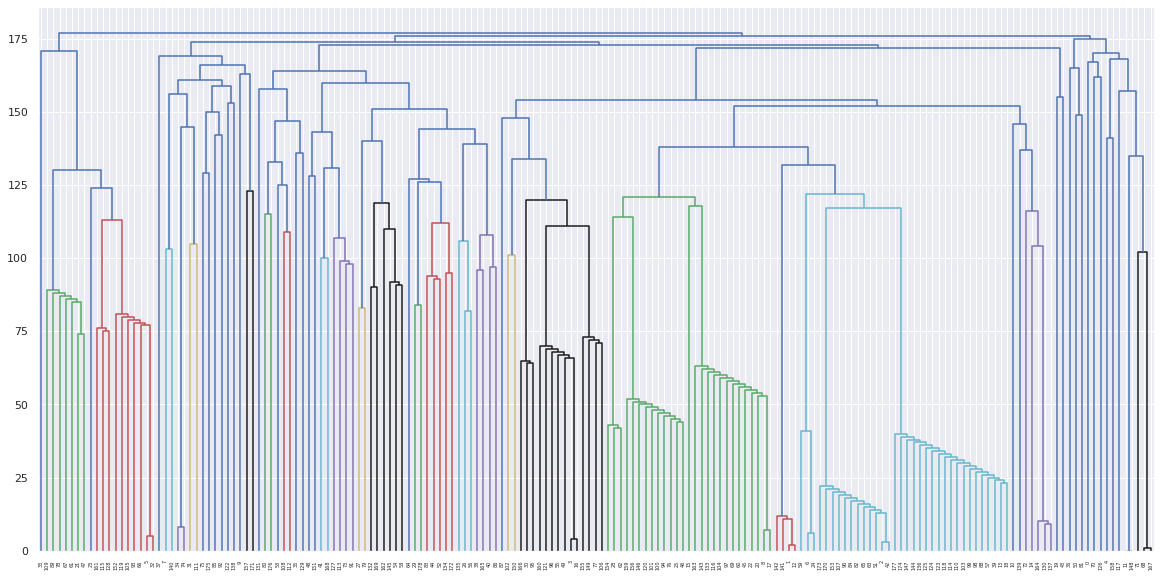

In [99]:
# answer goes here
plt.figure(figsize=(20,10))
plot_dendrogram(clusters_df)


Finally, plot the resulting clusters on a map using the "scatter_geo" function from plotly.express. The map defaults to the entire world; the "scope" parameter is useful for narrowing down the region plotted in the map. The documentation can be found here:

https://www.plotly.express/plotly_express/#plotly_express.scatter_geo

Tip: If the markers on the map are too large, their size can be changed with the following line of code:

*fig.update_traces(marker=dict(size=...)))*

Do the clusters correspond to geographic areas you would expect? Experiment with other values for n_cluster and linkage and see how they affect the results.

In [100]:
# answer goes here
px.scatter_geo(data_frame=df1, lon = 'Longitude', lat='Latitude',scope='usa', color='cluster')